Philippe Joly 22-12-24

In [1]:
import numpy as np
import networkx as nx
from pyknotid.spacecurves import Knot
from pyknotid.catalogue.getdb import download_database
from pyknotid.catalogue.identify import get_knot
from pyknotid.make import named

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import colormaps

import skimage.io as io
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage import morphology

Could not import cythonised chelpers, using Python alternative. This will give the same result, but is slower.


In [2]:
i=1

# Knot Segementation and Skeletonization

In [3]:
img_original =  io.imread(f'./examples/{i}_knot.png')[...,:3]      
img_gray = rgb2gray(img_original)

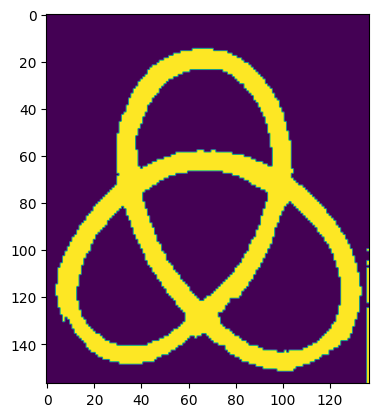

In [4]:
elevation_map = sobel(img_gray)

markers = np.zeros_like(img_gray)
markers[img_gray<30/255]=1
markers[img_gray>150/255]=2
markers = markers.astype(np.int32)

bw = watershed(elevation_map, markers)-1
# bw = blur(bw, 10, 16)
plt.imshow(bw)

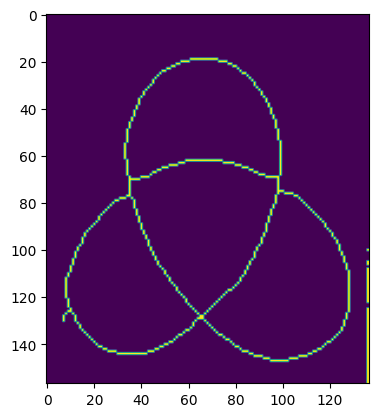

In [5]:
skeleton = morphology.skeletonize(bw)
plt.imshow(skeleton)

# Graph transposition and cleaning

## Graph Creation

In [6]:
def show_graph(G):
    plt.figure(figsize=(10, 10))
    pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Flip y-axis for correct orientation
    nx.draw(G, pos, node_size=0.1, node_color='blue', with_labels=False)
    plt.title("Graph Representation")
    plt.show()

In [7]:
def sk_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for r in range(rows):
        for c in range(cols):
            if skeleton[r, c]:
                G.add_node((r, c))

    # Add edges between adjacent pixels
    slants = [(-1, -1),(-1, 1),(1, -1),(1, 1)]
    
    directions = [(-1, 0),(0, -1),(0, 1),(1, 0)]

    for node in G.nodes():
        r, c = node
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if (nr, nc) in G.nodes():
                G.add_edge((r, c), (nr, nc))
        
        if G.degree((r,c))<2:
            for dr, dc in slants:
                nr, nc = r + dr, c + dc
                if (nr, nc) in G.nodes():
                    G.add_edge((r, c), (nr, nc))
            
    return G

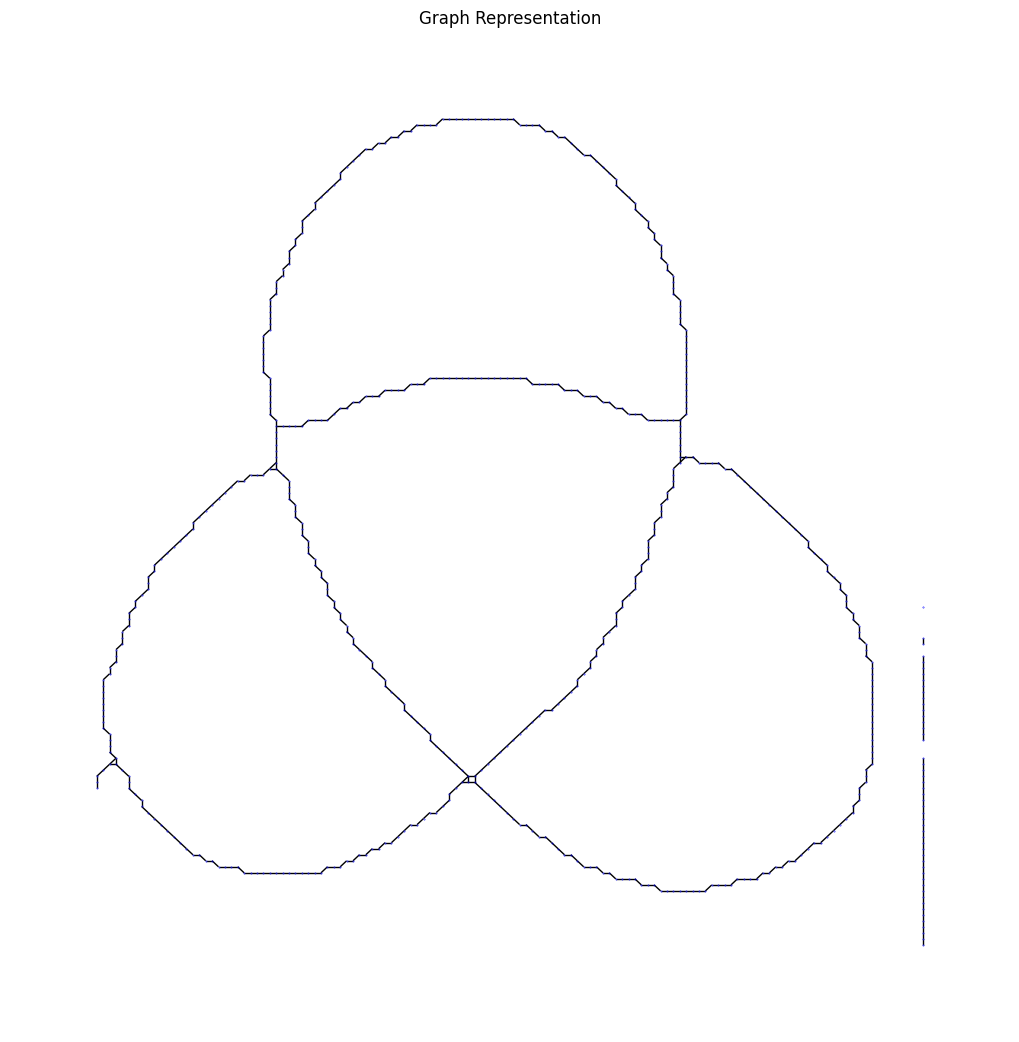

In [8]:
G = sk_graph(skeleton)
show_graph(G)

## Cleaning

In [9]:
# Remove small loops
def remove_loops(G, limit):
    for i, node in enumerate(G.nodes):
        if G.degree(node) > 2:
            for neighbour in G.neighbors(node):
                flag = False
                if neighbour !=list(G.nodes)[i-1]:
                    flag = search_loop(G, node, node, neighbour, 0, limit)

                if flag:
                    break

def search_loop(G, init_node, prev_node, node, count, limit):
    if node == init_node:
        G.remove_edge(prev_node, node)
        return True
    
    flag = False 

    if count < limit:
        for neighbour in G.neighbors(node):
            if neighbour != prev_node:
                flag = search_loop(G, init_node, node, neighbour, count+1, limit)

            if flag:
                break

    return flag

In [10]:
# remove unlooped branches
def remove_unconnected(G, limit):
    removable = []

    for node in G.nodes:
        if G.degree(node) < 2:
            rmv = []
            flag = search_branch(G, None, node, rmv, 0, limit)
            if flag:
                removable.extend(rmv)
                
    removable = list(set(removable))
    for node in removable:
        G.remove_node(node)

def search_branch(G, prev_node, node, removable, count, limit):
    if G.degree(node) > 2:
        return True
    
    if count >= limit:
        return False
    
    removable.append(node)
    for neighbour in G.neighbors(node):
        if neighbour != prev_node:
            return search_branch(G, node, neighbour, removable, count+1, limit)
        
    return True

In [11]:
# connect close intersections
def connect_int(G, limit):
    ints = []
    connections = []
    removes = []
    for i, node in enumerate(G.nodes):
        if G.degree(node) == 3:
            for neighbour in G.neighbors(node):
                if neighbour != list(G.nodes)[i-1]:
                    inter, removable = search_int(G, node, neighbour, 0, limit, [])
                    if inter and (inter, node) not in connections:
                        ints.extend([node,inter])
                        connections.append((node, inter))
                        removes.extend(removable)
    
    removes = list(set(removes))
    for node in removes:
        G.remove_node(node)
    
    new_ints = []
    connections = list(set(connections))
    for int1, int2 in connections:
        r, c = (int1[0]+int2[0])//2, (int1[1]+int2[1])//2
        G.add_node((r, c))

        for neighbour in list(G.neighbors(int1))+list(G.neighbors(int2)):
            if neighbour != (r,c):
                G.add_edge((r,c), neighbour)
        new_ints.append((r,c))
    
    ints = list(set(ints))
    for node in ints:
        if node not in new_ints:
            G.remove_node(node)
   
def search_int(G, prev_node, node, count, limit, removable):
    if G.degree(node) == 3:
        return node, removable
    
    if count > limit:
        return None, None

    for neighbour in G.neighbors(node):
        if neighbour != prev_node:
            removable.append(node)
            return search_int(G, node, neighbour, count+1, limit, removable)  

    return None, None  

In [12]:
# tying up loose ends
def dis(n1, n2):
    return np.sqrt((n2[0]-n1[0])**2+(n2[1]-n1[1])**2)

def tying_loose_ends(G, limit):
    threes = []
    singles = []

    for node in G.nodes:
        if G.degree(node) == 3:
            threes.append(node)
        if G.degree(node) == 1:
            singles.append(node)

    singles = connect_singles(G, singles, limit)
    connect_1_3(G, singles, threes, limit)

def connect_1_3(G, singles, threes, limit):
    l3 = len(threes)
    l1 = len(singles)
    if l1 == 0 or l3 == 0:
        return threes+singles
    
    distances = []
    for i in range(l1):
        dist = []
        for j in range(l3):
            dist.append((j+l1, dis(singles[i], threes[j])))
        dist = sorted(dist, key=lambda x: x[1])
        distances.append(dist)
    for i in range(l3):
        dist = []
        for j in range(l1):
            dist.append((j, dis(threes[i], singles[j])))
        dist = sorted(dist, key=lambda x: x[1])
        distances.append(dist)

    closests, _, single = match_closest([], distances, singles+threes)

    for el in closests:
        if el[2] < limit:
            G.add_edge(el[0], el[1])
    
    return single

def connect_singles(G, singles, limit):
    l1 = len(singles)
    if l1 < 2:
        return singles
    
    distances = []
    for i in range(l1-1):
        dist = []
        for j in range(i+1,l1):
            dist.append((j, dis(singles[i], singles[j])))
        dist = sorted(dist, key=lambda x: x[1])
        distances.append(dist)

    closests, _, single = match_closest([], distances, singles)
    
    for el in closests:
        if el[-1] < limit:
            G.add_edge(el[0], el[1])
    
    return single                     

def match_closest(closests, distances, singles):
    if len(singles) < 2:
        return closests, distances, singles
    
    closest = []
    closest_idx = []
    for i in range(len(singles)-1):
        j = distances[distances[i][0][0]][0][0]
        if j == i:
            if [singles[j],singles[i], distances[j][0][1]] not in closest:
                closest.append([singles[i],singles[distances[i][0][0]], distances[i][0][1]])
                closest_idx.extend([i,distances[i][0][0]])
    
    closests.extend(closest)
    closest_idx = sorted(list(set(closest_idx)), reverse=True)
    new_singles = singles.copy()

    for idx in closest_idx:
        new_singles.pop(idx)
        distances.pop(idx)
    
    for i in range(len(distances)):
        distances[i] = [x for x in distances[i] if x[0] not in closest_idx]

    return match_closest(closests, distances, new_singles)  

In [13]:
structs = list(nx.connected_components(G))
largest_struct = max(structs, key=len)
G = G.subgraph(largest_struct).copy()

In [14]:
scale = 1 # scaling factor to adjust for picture resolution (1 for example_1.png)

remove_loops(G, scale*5)
for i in range(5):
    remove_unconnected(G, scale*2*(i+1))
connect_int(G, scale*15)
tying_loose_ends(G, scale*30)
connect_int(G, scale*25)
remove_unconnected(G, scale*25)

## Result

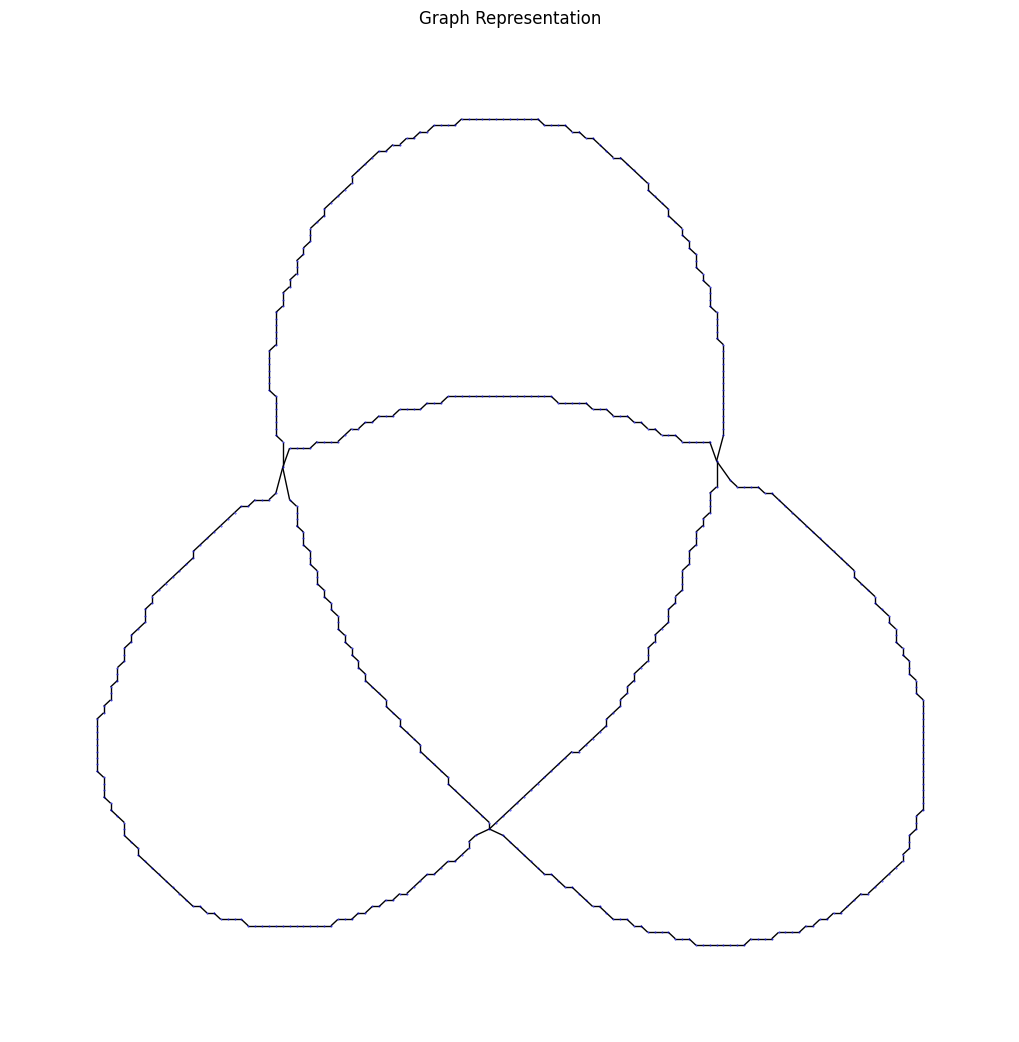

In [15]:
show_graph(G)

In [16]:
errors = []
for node in G.nodes:
    deg = G.degree(node)
    if deg != 2 and deg != 4:
        errors.append((deg, node))

err_num = len(errors)
if err_num>0:
    print(err_num, "errors in the graphing")
    print(errors)
else:
    print("No apparent Errors in Graph")

No apparent Errors in Graph


# Crossing Analysis

In [17]:
def opposite_pair(n):
    n0 = n[0]
    
    for i in range(2):
        ni = n[i+1]
        if n0[0]-ni[0] != 0:
            m = float(n0[1]-ni[1])/float(n0[0]-ni[0])
            b = n0[1]-m*n0[0]

            over = 0
            for j in range(3):
                if i == j:
                    pass

                y_pred = m*n[j+1][0]+b
                
                if n[j+1][1] > y_pred:
                    over += 1
        else:
            over = 0
            for j in range(3):
                if i == j:
                    pass
                if n[j+1][0] > n0[0]:
                    over += 1
        
        if over == 1:
            p1 = [n0, n[i+1]]
            p2 = [el for el in n if el not in p1]
            return (p1, p2)
    
    return ([n0, n[-1]], [n[1], n[2]])

In [18]:
def show_int(node, pairs, img, r, c):
    neighbors = pairs[0] + pairs[1]

    # Calculate the bounds of the square to fit all neighbors
    x_coords = [node[0]] + [neighbor[0] for neighbor in neighbors]
    y_coords = [node[1]] + [neighbor[1] for neighbor in neighbors]

    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    # Adjust the size of the square if neighbors don’t fit
    square_size = max(c, max(max_x - min_x, max_y - min_y) + 2 * r)

    # Define the square boundaries
    square_left = node[0] - square_size 
    square_right = node[0] + square_size 
    square_bottom = node[1] - square_size 
    square_top = node[1] + square_size 

    # Crop the image to the square boundaries
    img_cropped = img[int(max(0, square_left)):int(min(img.shape[1], square_right)),
                      int(max(0, square_bottom)):int(min(img.shape[0], square_top))]

    # Plot the cropped image
    fig, ax = plt.subplots()
    ax.imshow(img_cropped, extent=[square_left, square_right, square_bottom, square_top])

    # Plot the neighbors and the node
    for n in range(2):
        circle1 = plt.Circle((pairs[0][n][0], pairs[0][n][1]), r, color="red", fill=True)
        circle2 = plt.Circle((pairs[1][n][0], pairs[1][n][1]), r, color="blue", fill=True)
        ax.add_patch(circle1)
        ax.add_patch(circle2)

    node_circle = plt.Circle((node[0], node[1]), r, color='black', fill=True)
    ax.add_patch(node_circle)

    # Set plot limits to match the cropped image
    ax.set_xlim(square_left, square_right)
    ax.set_ylim(square_bottom, square_top)

    plt.show()

In [19]:
for node in list(G.nodes):
    r, c = node
    G = nx.relabel_nodes(G, {node: (r, c, 0)})

edges = list(G.edges)
G.remove_edges_from(edges)
for edge in edges:
    node1, node2 = edge
    G.add_edge((node1[0], node1[1], 0), (node2[0], node2[1], 0))

In [20]:
new_ints = []
for node in G.nodes:
    if G.degree(node) == 4:
        neighbors = list(G.neighbors(node))
        p1, p2 = opposite_pair(neighbors)
        new_ints.append([node, (p1, p2)])


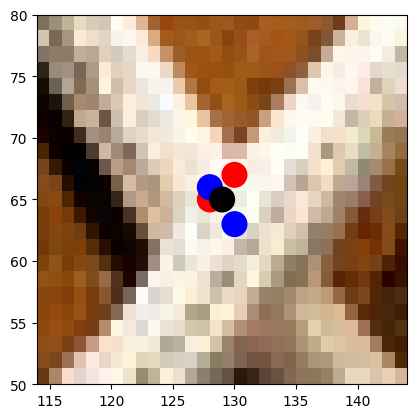

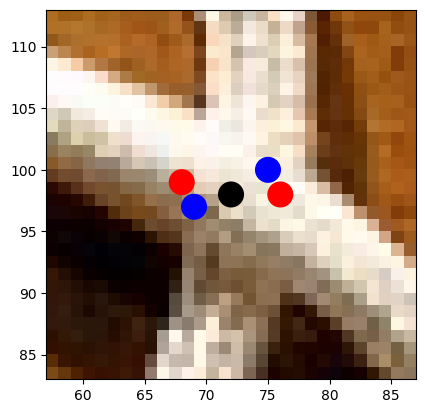

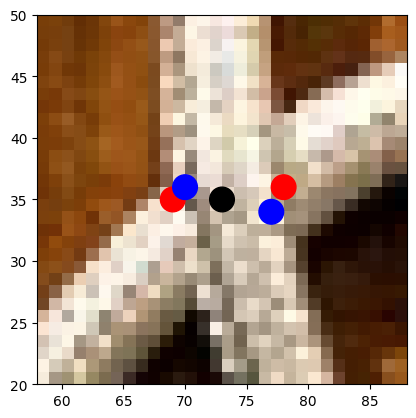

In [21]:
c = 15
for img_int in new_ints:
    show_int(img_int[0], img_int[1], img_original, 1, 15)

In [22]:
blue_up = [0,0,1]

In [23]:
for i, inter in enumerate(new_ints):
    top_pair = inter[1][blue_up[i]]

    new_nodes = [(),()]
    for i in range(2):
        G.remove_edge(top_pair[i], inter[0])
        new_nodes[i] = (top_pair[i][0], top_pair[i][1], 1)
        G.add_node(new_nodes[i])

        for n in list(G.neighbors(top_pair[i])):
            G.add_edge(new_nodes[i], n)
        
        G.remove_node(top_pair[i])

    G.add_edge(new_nodes[0], new_nodes[1])

In [24]:
c=0
for node in G.nodes:
    if G.degree(node) != 2:
        c+=1
print(c)

0


# Knot Conversion and Reduction

In [25]:
def graph_to_np_array(G):
    start_node = None
    for node in G.nodes:
        start_node = node
        if G.degree(node) == 1:
            break

    ordered_points = []
    visited = set()
    current_node = start_node
    prev_node = None

    while current_node is not None:
        ordered_points.append(current_node)
        visited.add(current_node)
        neighbors = list(G.neighbors(current_node))
        next_node = None
        for neighbor in neighbors:
            if neighbor != prev_node and neighbor not in visited:
                next_node = neighbor
                break
        prev_node = current_node
        current_node = next_node

    points_array = np.array(ordered_points)
    return points_array

In [26]:
def plotter(knot, s=1):
    pts = knot.points
    pts = np.append(pts, [pts[0]], axis=0)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    pts = np.array_split(pts, s)

    for i in range(s):
        ax.plot(pts[i][:,0], pts[i][:,1], pts[i][:,2])

    plt.show()

In [27]:
def plot_tube(knot, radius=0.1, resolution=50, colormap='viridis', **kwargs):
    def generate_tube(centerline, radius, resolution):
        """Generates vertices for a tube around a centerline."""
        vertices = []
        for i in range(len(centerline) - 1):
            p1 = centerline[i]
            p2 = centerline[i + 1]
            direction = p2 - p1
            direction = direction / np.linalg.norm(direction)
            
            # Generate two perpendicular vectors to the direction
            if np.allclose(direction, [1, 0, 0]):
                perp1 = np.cross(direction, [0, 1, 0])
            else:
                perp1 = np.cross(direction, [1, 0, 0])
            perp2 = np.cross(direction, perp1)
            perp1 /= np.linalg.norm(perp1)
            perp2 /= np.linalg.norm(perp2)
            
            # Create circular cross-section
            circle_points = [
                p1 + radius * (np.cos(theta) * perp1 + np.sin(theta) * perp2)
                for theta in np.linspace(0, 2 * np.pi, resolution)
            ]
            vertices.append(circle_points)
        return np.array(vertices)

    # Generate tube vertices
    pts = knot.points
    points = np.append(pts, [pts[0]], axis=0)
    tube_vertices = generate_tube(points, radius, resolution)
    
    # Calculate distances between consecutive points as color values
    distances = np.linalg.norm(points[1:] - points[:-1], axis=1)
    normalized_distances = (distances - distances.min()) / (distances.max() - distances.min())
    colors = colormaps[colormap](normalized_distances)
    
    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    # Plot tube as a collection of polygons with colormap
    for i in range(len(tube_vertices) - 1):
        for j in range(resolution - 1):
            verts = [
                tube_vertices[i][j],
                tube_vertices[i][j + 1],
                tube_vertices[i + 1][j + 1],
                tube_vertices[i + 1][j],
            ]
            color = colors[i]  # Use the distance-based color for this segment
            poly = Poly3DCollection([verts], facecolor=color, edgecolor='none', **kwargs)
            ax.add_collection3d(poly)
    
    # Set axes limits for better visualization
    ax.set_xlim(points[:, 0].min() - radius, points[:, 0].max() + radius)
    ax.set_ylim(points[:, 1].min() - radius, points[:, 1].max() + radius)
    ax.set_zlim(points[:, 2].min() - radius, points[:, 2].max() + radius)

    plt.show()

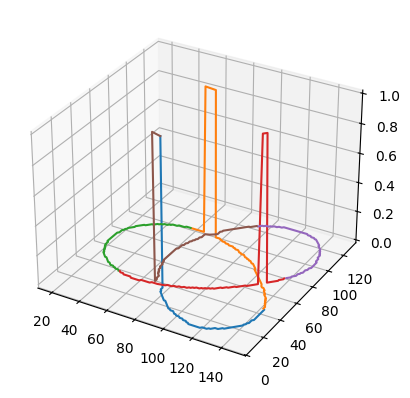

In [28]:
pts = graph_to_np_array(G)
k = Knot(pts)
plotter(k, 6)

In [29]:
# download_database()

In [30]:
knot_id = k.identify()[0]
print(knot_id)

Finding crossings
i = 500 / 523
3.0 crossings found

Simplifying: initially 6 crossings
-> 6 crossings after 1 runs
Simplifying: initially 6 crossings
-> 6 crossings after 1 runs
Simplifying: initially 6 crossings
-> 6 crossings after 1 runs
<Knot 3_1>


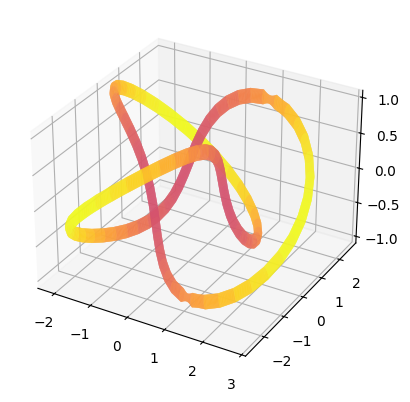

In [31]:
rep_knot = named.k3_1()
plot_tube(rep_knot, colormap="plasma")